In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import osmnx as ox
import contextily as ctx
import folium
import requests
import json
import seaborn as sns
from mapclassify import Quantiles, EqualInterval, FisherJenks

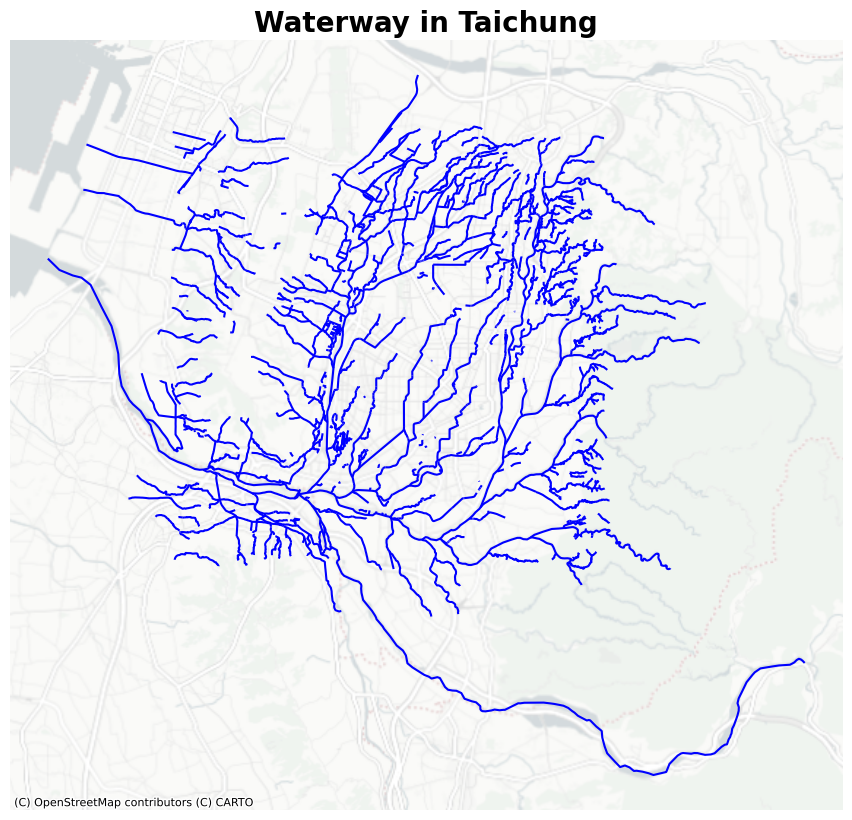

In [2]:
# Define the coordinate reference system (CRS) for Taiwan
taiwan_crs = 'EPSG:3826'

# The OSM 'tags' parameter filters for any feature tagged as a waterway
waterways = ox.features_from_address("Taichung, Taiwan", tags={"waterway": True}, dist=10000)
waterways = waterways.reset_index()

# Filter the waterways to only include valid geometry types: LineString or MultiLineString
valid_geom = ['LineString', 'MultiLineString']
waterways = waterways[waterways.geometry.geom_type.isin(valid_geom)]

# Convert the coordinate system of the waterways to the specified Taiwan CRS
waterways = waterways.to_crs(taiwan_crs)

# Create a figure and axis for plotting with specified size
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Waterway in Taichung", fontsize=20, fontweight='bold')
ax.set_axis_off()

# Plot waterways on the axis with blue color and line width of 1.5
waterways.plot(ax=ax, color='blue', linewidth=1.5)

# Add a basemap to the plot using CartoDB's Positron style
ctx.add_basemap(ax, crs=waterways.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)

# Display the plot
plt.show()

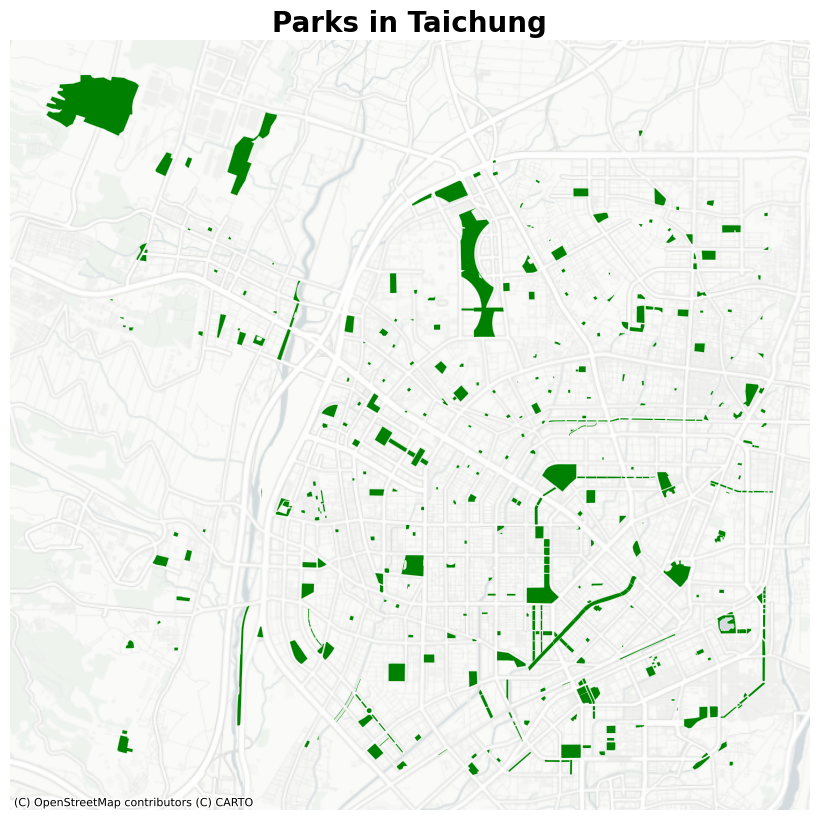

In [3]:
# Get park features within 5 km of Taichung, Taiwan
parks = ox.features_from_address("Taichung, Taiwan", tags={"leisure": "park"}, dist=5000)
parks = parks.reset_index()

valid_geom = ['Polygon', 'MultiPolygon']
parks = parks[parks.geometry.geom_type.isin(valid_geom)]

# Convert to Taiwan's coordinate system
parks = parks.to_crs(taiwan_crs)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Parks in Taichung", fontsize=20, fontweight='bold')
ax.set_axis_off()

# Plot parks in green with light green edges
parks.plot(ax=ax, color='green', edgecolor='lightgreen', linewidth=0.1)

ctx.add_basemap(ax, crs=parks.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)

plt.show()

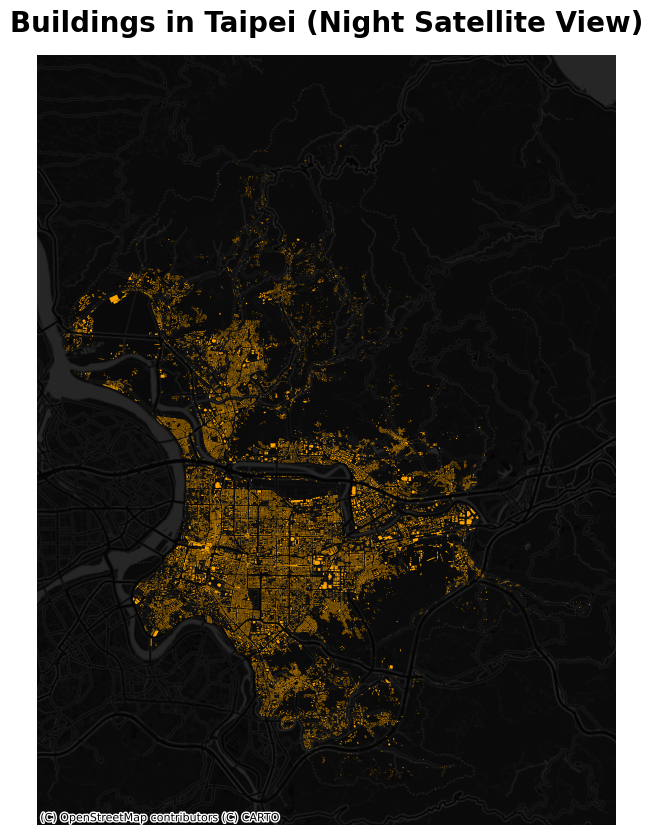

In [4]:
# Get all building features in Taipei
buildings = ox.features_from_place("Taipei, Taiwan", tags = {"building": True}) 
buildings = buildings.reset_index()

# Keep only polygon-type geometries
buildings = buildings[(buildings.geometry.geom_type == 'Polygon') | (buildings.geometry.geom_type == 'MultiPolygon')]
buildings = buildings.to_crs(taiwan_crs)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title("Buildings in Taipei (Night Satellite View)", fontsize=20, fontweight='bold')
ax.set_axis_off()

# Plot buildings in orange
buildings.plot(ax=ax, color = 'orange')

ctx.add_basemap(ax, crs=buildings.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterNoLabels)

plt.show()

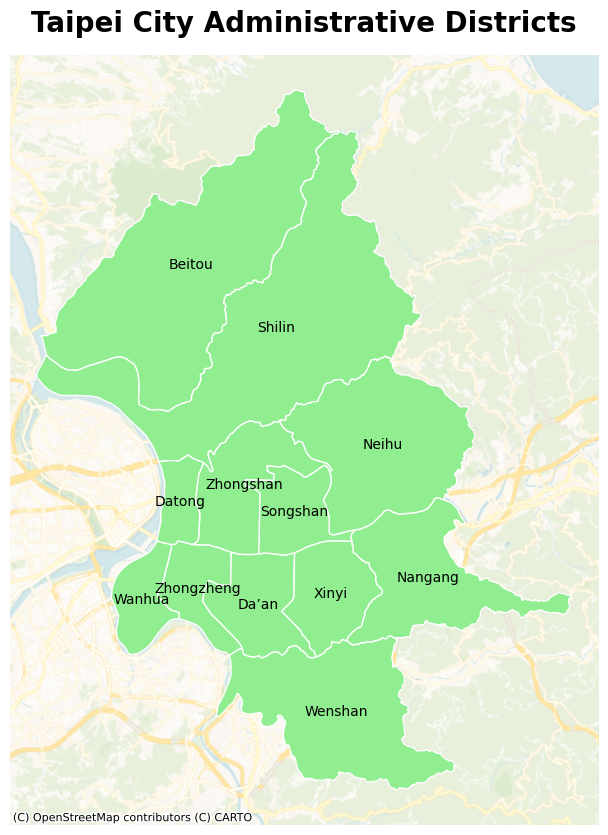

In [5]:
# Load Taiwan administrative district GeoJSON data from g0v
district_gdf = gpd.read_file('https://raw.githubusercontent.com/g0v/twgeojson/refs/heads/master/json/twTown1982.geo.json')

# Filter for Taipei City
taipei = district_gdf[district_gdf['COUNTYNAME'] == '台北市'].copy()

#This converts OSMnx’s default geographic coordinates (EPSG:4326) to Taiwan’s local projected system (EPSG:3826)
taipei = taipei.to_crs(taiwan_crs)

# Load district name translations (Chinese to English)
with open("data/district_english_translate.json", "r", encoding='utf-8') as f:
    cities_map = json.load(f)

# Map Chinese district names to English
district_name = cities_map.get('台北市', {})
taipei['TOWNNAME_EN'] = taipei['TOWNNAME'].map(district_name)

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Taipei City Administrative Districts", fontsize=20, fontweight='bold')
ax.set_axis_off()

# Plot districts with light green fill and white borders
taipei.plot(ax=ax, edgecolor='white', facecolor='lightgreen', linewidth=1)

# Add district names at centroid positions
for idx, row in taipei.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['TOWNNAME_EN'], fontsize=10, ha='center', va='center')


ctx.add_basemap(ax, crs=taipei.crs.to_string(), source=ctx.providers.CartoDB.VoyagerNoLabels, zoom=12)

plt.show()

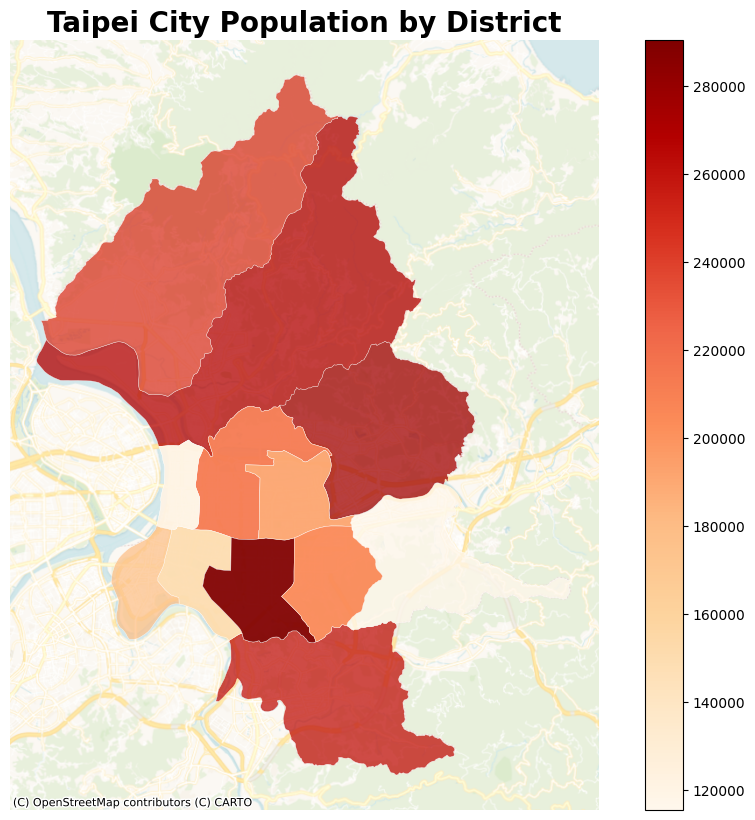

In [6]:
# Fetch population data from Taipei open data API
response = requests.get('https://data.taipei/api/v1/dataset/9681db4c-fb1b-4a23-9013-e74483b6b046?scope=resourceAquire')
data_json = response.json()

# Convert JSON data to DataFrame
pop_data = pd.DataFrame(data_json['result']['results'])

# Clean and filter district names
pop_data['TOWNNAME'] = pop_data['行政區'].str.strip()
pop_data = pop_data[pop_data['行政區'] != '總計']

# Convert population column to numeric
pop_data['人口數_合計數量'] = pd.to_numeric(pop_data['人口數_合計數量'], errors='coerce')

# Merge population data with Taipei GeoDataFrame
taipei_pop = taipei.merge(pop_data, on='TOWNNAME')
taipei_pop = taipei_pop.to_crs(epsg=3826)

# Map district names to English
district_name = cities_map.get('台北市', {})
pop_data['TOWNNAME'] = pop_data['行政區']
pop_data['TOWNNAME_EN'] = pop_data['TOWNNAME'].map(district_name)

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Taipei City Population by District", fontsize=20, fontweight='bold')
ax.set_axis_off()

# Plot districts colored by population
taipei_pop.plot(ax=ax, column='人口數_合計數量', cmap='OrRd', alpha=0.75, linewidth=0.3, edgecolor='white', legend=True)

ctx.add_basemap(ax, crs=taipei_pop.crs.to_string(), source=ctx.providers.CartoDB.VoyagerNoLabels, zoom=12)

plt.show()

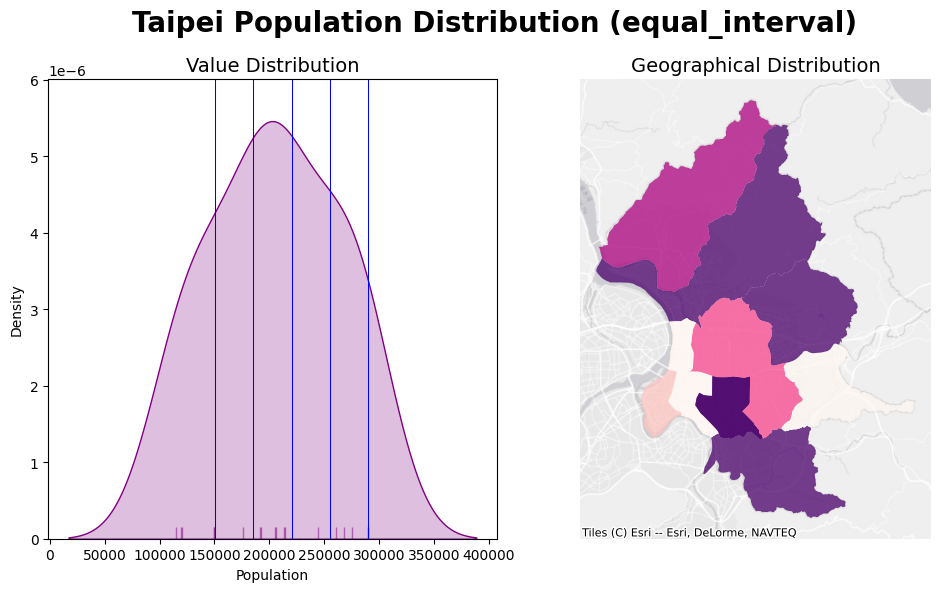

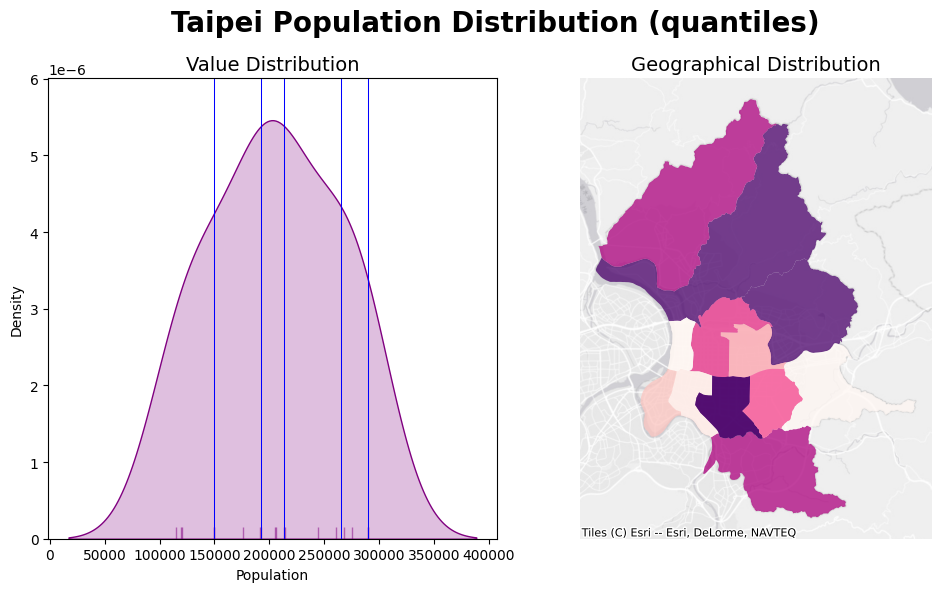

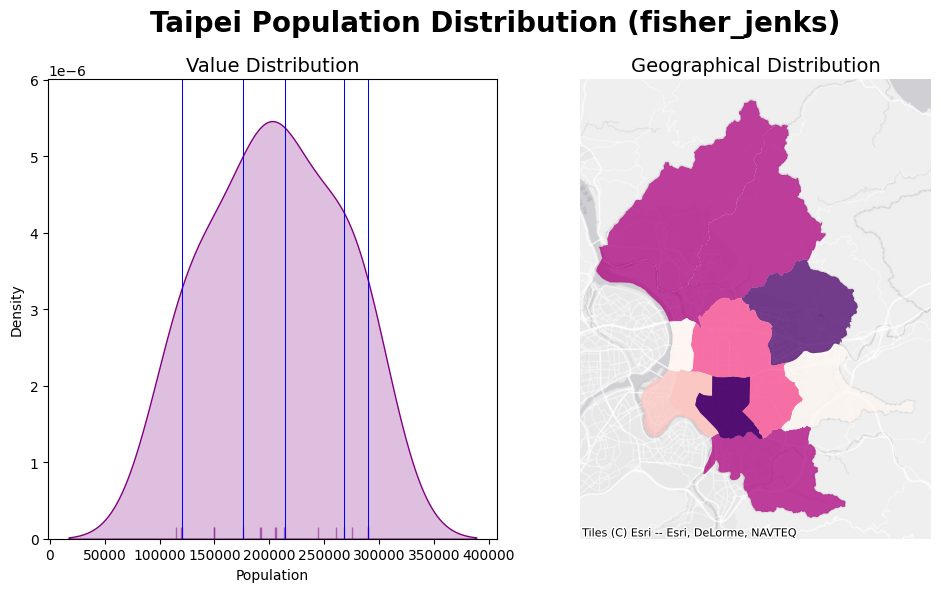

In [7]:
# Clean population data
pop_data['TOWNNAME'] = pop_data['行政區'].str.strip()
pop_data = pop_data[pop_data['TOWNNAME'] != '總計']
pop_data['人口數_合計數量'] = pd.to_numeric(pop_data['人口數_合計數量'], errors='coerce')

# Map district names to English
pop_data['TOWNNAME_EN'] = pop_data['TOWNNAME'].map(district_name)

# Merge population data with Taipei GeoDataFrame
taipei_pop = taipei.merge(pop_data, on='TOWNNAME')
taipei_pop = taipei_pop.to_crs(epsg=3826)

# Rename population column for clarity
taipei_pop = taipei_pop.rename(columns={'人口數_合計數量': 'Population'})

# Function to plot population using different classification schemes
def plot_scheme(gdf, column, scheme):
    # Define classification schemes
    schemes = {'equal_interval': EqualInterval, 'quantiles': Quantiles, 'fisher_jenks': FisherJenks}
    classification = schemes[scheme](gdf[column], k=5)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    # Plot value distribution with cut lines
    sns.kdeplot(gdf[column], fill=True, color='purple', ax=ax1)
    sns.rugplot(gdf[column], alpha=0.5, color='purple', ax=ax1)
    for cut in classification.bins:
        ax1.axvline(cut, color='blue', linewidth=0.75)
    ax1.set_title('Value Distribution', fontsize=14)

    # Plot geographical distribution using specified scheme
    gdf.plot(column=column, scheme=scheme, alpha=0.75, k=5, cmap='RdPu',
             ax=ax2, linewidth=0.5)
    ax2.set_axis_off()
    ax2.set_title('Geographical Distribution', fontsize=14)

    ctx.add_basemap(ax2, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldGrayCanvas, zoom=12)

    fig.suptitle(f"Taipei Population Distribution ({scheme})", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot using different classification schemes
for scheme in ['equal_interval', 'quantiles', 'fisher_jenks']:
    plot_scheme(taipei_pop, 'Population', scheme)